딥러닝을 해킹하는 적대적 공격

- 딥러닝 모델의 착시를 유도하는 입력을 적대적 예제라고 한다. 
- 이러한 적대적 예제로 머신러닝 기반 시스템의 성능을 의도적으로 떨어드려 보안 문제를 일으키는 것을 적대적 공격이라 한다. 
- 특히 모델이 예민하게 반응하는 부분을 공략하는 경우가 많다. 
- 적대적 공격은 적절한 잡음을(노이즈)를 생성해 사람의 눈에는 똑같이 보이지만, 머신런이 모델을 헷갈리게 하는 것이 핵심이다. 
- 적대적 공격에선 오차를 줄이기보단 극대화 하는 쪽으로 잡음을 최적화 하게 된다.
- 잡음을 생성할때 모델 정보, 정답 유도 가능 여부, 여러 모델 동시 공격, 학습 필요 여부에 따라 종류가 나뉜다. 
    1) 분류기준에 따른 적대적 예제 잡음 생성 방법
        - 기울기같은 모델 정보 필요여부에 따라, 모델 정보를 토대로 잡음 생성하는 화이트박스, 없이 생성하는 블랙박스로 나뉜다. 
        - 원하는 정답으로 유도할 수 있다면 표적, 아니면 비표적
        - 잡음 생성 위해 반복학습(최적화)가 필요하면 반복, 아니면 원샷
        - 한 잡음이 특정 입력에만 적용인지, 모든 이미지 적용인지로 나눌 수 있다. 
    - 가장 강력한 공격 방법은 모델 정보가 필요없고, 원하는 정답으로 유도가능하고, 복잡한 학습이 필요 없으며, 여러 모델에 동시 적용가능한 방법이다. 
    - 하지만 각 특징에는 기회비용이 존재하므로 완벽하게 공격하기는 어렵다. 

    2) FSGM공격
    - FSGM은 반복된 학습 없이 잡음을 생성하는 원샷 공격으로, 입력 이미지 대한 기울기 정보를 추출하여 잡음 생성
    - 공격 목표를 정할 수 없는 논 타겟 방식이자, 대상 모델의 정보가 필요한 화이트 박스 방식이다. 
    

In [3]:
#FSGM 

#라이브러리 임포트
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
#토치비전은 AlexNet, VGG, ResNet, SqueezeNet, DenseNet, Inception등 여러 모델 제공

from PIL import Image
import json
import matplotlib.pyplot as plt

#예제에서는 ResNet101이용

model = models.resnet101(pretrained = True) #학습이 완료된 모델이용
model.eval()

CLASSES = json.load(open('./08-딥러닝을_해킹하는_적대적_공격/imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\cndak/.cache\torch\checkpoints\resnet101-5d3b4d8f.pth


In [4]:
#공격이미지로드
#예제 웰시코기 파일
img = Image.open('./08-딥러닝을_해킹하는_적대적_공격/imagenet_samples/corgie.jpg')

#배치를 뜻하는 1차원이 추가된 224*224 텐서로 변환
img_transforms = transforms.Compose([transforms.Resize((224,224), Image.BICUBIC),
                                    transforms.ToTensor(),])
img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print('이미지 텐서 shape :', img_tensor.size())


이미지 텐서 shape : torch.Size([1, 3, 224, 224])


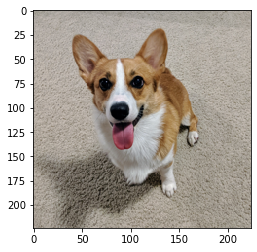

In [5]:
#원본 이미지 텐서의 시각화를 위해 squeeze()함수로 차원을 줄이고 detach()함수로 원본 이미지 텐서와의 연걸 끊고
#transpose()함수로 뒤집힌 이미지를 제자리로 돌려놓고 넘파이 행렬로 변환 및 이미지 시각화
original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()
plt.imshow(original_img_view)

In [6]:
#공격전 성능 확인
output = model(img_tensor)
prediction = output.max(1, keepdim = False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print('예측 레이블 번호 :', prediction_idx)
print('레이블 이름 :', prediction_name)

예측 레이블 번호 : 263
레이블 이름 : Pembroke, Pembroke Welsh corgi


In [7]:
#FSGM 공격함수 정의 
#입력 이미지의 기울기 정보를 추출하여 왜곡한 후, 원본 이미지에 더하는 것
#모델을 헷갈리게 하려면 모델의 오차값을 극대화해야 한다. (잡음이 기울기 방향으로 최적화하도록 함)

def fgsm_attack(image, epsilon, gradient):
    #기울기 원소의 sign값 구함 ( 기울기 방향성을 알 수 있도록)
    sign_gradient = gradient.sign()
    #이미지 각 픽셀값을 sign_gradient 뱡향으로 epsilon만큼 조절 ->epsilon은 학습률과 같은 개념으로 잡음이 얼마나 커지게 할지 제한하는 역할
    perturbed_image = image + epsilon *sign_gradient
    #0~1사이의 sign값을 벗어나는 값 조절
    perturbed_image=torch.clamp(perturbed_image, 0,1)
    return perturbed_image

In [8]:
#원본 이미지에 대한 기울기 추출을위해 requires_grad_(True)함수를 호출해 기울기 보존 명시
img_tensor.requires_grad_(True)

#이미지 통과
output = model(img_tensor)

#오차값
loss = F.nll_loss(output, torch.tensor([263]))

#기울기 구하기
model.zero_grad()
loss.backward()

In [9]:
#이미지 기울기 추출
gradient = img_tensor.grad.data

#적대적 예제 생성
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

In [13]:
#적대적 예제를 모델에 통과시켜 예측 확인
output = model(perturbed_data)

#적대적 예제 성능확인
perturbed_prediction = output.max(1, keepdim=True)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print('에측 레이블 번호 :', perturbed_prediction_idx)
print('레이블 이름 :', perturbed_prediction_name)

에측 레이블 번호 : 172
레이블 이름 : whippet


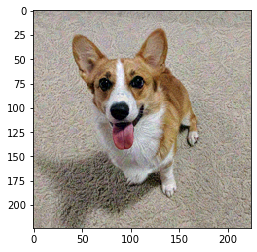

In [15]:
#적대적 예제 시각화

#넘파이 행렬변환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

사람의 눈에는 원본이미지와 크게 차이가 없다. ( 주면 이미지 무늬를 제외하고 )

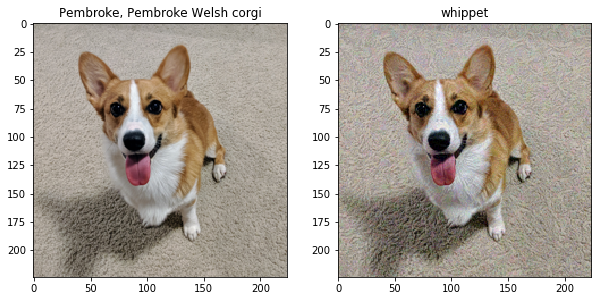

In [17]:
#원본과 적대적 예제 나란히 시각화
f, a = plt.subplots(1,2, figsize = (10,10))

#원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

#적대적예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)
plt.show()

딥러닝의 성능이 대단하여도 약점이 있다는 사실을 알 수 있고, 적대적 예제 생성 방법과, 방어에 대한 연구가 활발히 진행되고 있다. 